In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split


def preprocess_bank_data(input_file, output_file):
    data = pd.read_csv(input_file, sep=';')
    
    categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'poutcome']
    
    for feature in categorical_features:
        mode_value = data[feature].mode()[0]
        data[feature] = data[feature].replace('unknown', mode_value) # replace 'unknown' with mode valuen
    
    label_encoders = {}
    
    for feature in categorical_features:
        le = LabelEncoder()
        data[feature] = le.fit_transform(data[feature])
        label_encoders[feature] = le  
    
    data['y'] = LabelEncoder().fit_transform(data['y'])
    
    data.to_csv(output_file, index=False)
    print(f"Preprocessed data saved to {output_file}")
    
    return label_encoders
label_encoders = preprocess_bank_data('../data.csv', '../preprocessed_data.csv')
    
# the assigned labels with their corresponding values can be accessed as follows:
for feature, le in label_encoders.items():
    print(f"Encoded values for {feature}:")
    for i, category in enumerate(le.classes_):
        print(f"{category} -> {i}")


In [ ]:
os.makedirs('data', exist_ok=True)

df = pd.read_csv('../preprocessed_data.csv')

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv('../data/train.csv', index=False)
test_df.to_csv('../data/test.csv', index=False)
val_df.to_csv('../data/val.csv', index=False)

print(f"Original data shape: {df.shape}")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Validation data shape: {val_df.shape}")

In [1]:
import pandas as pd
import numpy as np
import os
import json
from collections import Counter

class Node:
    """A decision tree node class"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, categorical=False, categories=None):
        self.feature = feature  # Feature index to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left  # Left subtree
        self.right = right  # Right subtree
        self.value = value  # Predicted value for a leaf node
        self.categorical = categorical  # Whether the feature is categorical
        self.categories = categories  # List of categories in the left child (for categorical features)

    def is_leaf(self):
        """Check if the node is a leaf node"""
        return self.value is not None

class DecisionTree:
    """Decision Tree classifier implementation from scratch"""
    def __init__(self, max_depth=None, min_samples_split=2, min_impurity_decrease=0.0, criterion='gini'):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.min_impurity_decrease = min_impurity_decrease  # Minimum decrease in impurity required for split
        self.criterion = criterion  # Splitting criterion ('gini' or 'entropy')
        self.root = None  # Root node of the tree
        self.feature_types = None  # Types of features (categorical or continuous)
        
    def _is_categorical(self, X, feature_idx):
        """Determine if a feature is categorical based on its values"""
        unique_values = np.unique(X[:, feature_idx])
        return len(unique_values) < 10 and np.all(np.mod(unique_values, 1) == 0) # handling categorical features with less than 10 unique values and integer values which are common in categorical features and this will help in handling continuous features.
    
    def _determine_feature_types(self, X):
        """Determine the type of each feature (categorical or continuous)"""
        n_features = X.shape[1]
        feature_types = []
        
        for i in range(n_features):
            if self._is_categorical(X, i):
                feature_types.append('categorical')
            else:
                feature_types.append('continuous')
                
        return feature_types
    
    def _calculate_entropy(self, y):
        """Calculate entropy of a target array"""
        class_counts = Counter(y)
        n_samples = len(y)
        entropy = 0.0
        
        for count in class_counts.values():
            p = count / n_samples
            entropy -= p * np.log2(p)
            
        return entropy
    
    def _calculate_gini(self, y):
        """Calculate Gini impurity of a target array"""
        class_counts = Counter(y)
        n_samples = len(y)
        gini = 1.0
        
        for count in class_counts.values():
            p = count / n_samples
            gini -= p ** 2
            
        return gini
    
    def _calculate_impurity(self, y):
        """Calculate impurity based on the criterion"""
        if self.criterion == 'entropy':
            return self._calculate_entropy(y)
        else:  # Default to Gini
            return self._calculate_gini(y)
    
    def _calculate_information_gain(self, y, y_left, y_right):
        """Calculate information gain for a split"""
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        
        parent_impurity = self._calculate_impurity(y)
        left_impurity = self._calculate_impurity(y_left)
        right_impurity = self._calculate_impurity(y_right)
        
        # Weighted average of children impurities
        children_impurity = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        
        return parent_impurity - children_impurity
    
    def _split_continuous(self, X, y, feature_idx):
        """Find the best threshold to split a continuous feature"""
        X_feature = X[:, feature_idx]
        sorted_indices = np.argsort(X_feature)
        
        # Sort X_feature and y based on the feature values
        sorted_X_feature = X_feature[sorted_indices]
        sorted_y = y[sorted_indices]
        
        # Consider only unique values as potential thresholds
        unique_values = np.unique(sorted_X_feature)
        if len(unique_values) <= 1:
            return None, None, -float('inf')
        
        # Calculate thresholds as midpoints between consecutive unique values
        thresholds = [(unique_values[i] + unique_values[i+1]) / 2 for i in range(len(unique_values)-1)]
        
        best_gain = -float('inf')
        best_threshold = None
        
        for threshold in thresholds:
            left_indices = X_feature <= threshold
            right_indices = ~left_indices
            
            # Skip if the split doesn't meet the minimum samples requirement
            if sum(left_indices) < self.min_samples_split or sum(right_indices) < self.min_samples_split:
                continue
            
            y_left = y[left_indices]
            y_right = y[right_indices]
            
            gain = self._calculate_information_gain(y, y_left, y_right)
            
            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
        
        return best_threshold, False, best_gain
    
    def _split_categorical(self, X, y, feature_idx):
        """Find the best category split for a categorical feature"""
        X_feature = X[:, feature_idx]
        unique_categories = np.unique(X_feature)
        
        if len(unique_categories) <= 1:
            return None, None, -float('inf')
        
        best_gain = -float('inf')
        best_categories = None
        
        # Try all possible binary partitions of categories
        # This is a simplified approach using a greedy method
        # For each category, put it alone in one subset and all others in the other subset
        for category in unique_categories:
            left_indices = X_feature == category
            right_indices = ~left_indices
            
            # Skip if the split doesn't meet the minimum samples requirement
            if sum(left_indices) < self.min_samples_split or sum(right_indices) < self.min_samples_split:
                continue
            
            y_left = y[left_indices]
            y_right = y[right_indices]
            
            gain = self._calculate_information_gain(y, y_left, y_right)
            
            if gain > best_gain:
                best_gain = gain
                best_categories = [category]
        
        return best_categories, True, best_gain
    
    def _find_best_split(self, X, y):
        """Find the best feature and threshold to split the data"""
        n_features = X.shape[1]
        best_gain = -float('inf')
        best_feature = None
        best_threshold = None
        best_categorical = False
        best_categories = None
        
        for feature_idx in range(n_features):
            if self.feature_types[feature_idx] == 'categorical':
                threshold, categorical, gain = self._split_categorical(X, y, feature_idx)
                categories = threshold  # For categorical, threshold is actually a list of categories
            else:
                threshold, categorical, gain = self._split_continuous(X, y, feature_idx)
                categories = None
            
            if gain > best_gain and threshold is not None:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold
                best_categorical = categorical
                best_categories = categories
        
        if best_gain <= self.min_impurity_decrease:
            return None, None, None, None
        
        return best_feature, best_threshold, best_categorical, best_categories
    
    def _split_data(self, X, y, feature, threshold, categorical, categories):
        """Split the data based on a feature and threshold"""
        if categorical:
            left_indices = np.isin(X[:, feature], categories)
        else:
            left_indices = X[:, feature] <= threshold
        
        right_indices = ~left_indices
        
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]
        
        return X_left, y_left, X_right, y_right
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Check stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_classes == 1:
            # Leaf node
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Find the best split
        best_feature, best_threshold, is_categorical, categories = self._find_best_split(X, y)
        
        # If no good split is found, create a leaf node
        if best_feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Split the data
        X_left, y_left, X_right, y_right = self._split_data(X, y, best_feature, best_threshold, is_categorical, categories)
        
        # Create a decision node and build subtrees
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return Node(
            feature=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            categorical=is_categorical,
            categories=categories
        )
    
    def fit(self, X, y):
        """Build the decision tree"""
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Determine feature types
        self.feature_types = self._determine_feature_types(X)
        
        # Build the tree
        self.root = self._build_tree(X, y)
        
        return self
    
    def _predict_sample(self, x, node):
        """Predict the class for a single sample"""
        if node.is_leaf():
            return node.value
        
        # Fix: Check if feature or threshold is None
        if node.feature is None or (not node.categorical and node.threshold is None):
            return node.value if node.value is not None else Counter(self.predict(np.array([x]))).most_common(1)[0][0]
        
        if node.categorical:
            if np.isin(x[node.feature], node.categories):
                return self._predict_sample(x, node.left)
            else:
                return self._predict_sample(x, node.right)
        else:
            if x[node.feature] <= node.threshold:
                return self._predict_sample(x, node.left)
            else:
                return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Predict classes for samples in X"""
        X = np.array(X)
        y_pred = [self._predict_sample(x, self.root) for x in X]
        return np.array(y_pred)
    
    def _calculate_error(self, X, y, node):
        """Calculate error for pruning evaluation"""
        # Fix: Handle the case where node isn't properly set up for prediction
        try:
            y_pred = [self._predict_sample(x, node) for x in X]
            return sum(y_pred != y) / len(y)
        except:
            # If there's an error, return a high error rate to prevent pruning
            return 1.0
    
    def _prune_node(self, node, X, y):
        """Prune a node if it improves performance"""
        if node is None or node.is_leaf():
            return
        
        # Recursively prune children
        if node.left is not None and not node.left.is_leaf():
            self._prune_node(node.left, X, y)
        if node.right is not None and not node.right.is_leaf():
            self._prune_node(node.right, X, y)
        
        # If both children are leaf nodes, consider pruning
        if (node.left is not None and node.right is not None and 
            node.left.is_leaf() and node.right.is_leaf()):
            
            # Calculate error with current split
            current_error = self._calculate_error(X, y, node)
            
            # Store the current subtrees
            left_backup = node.left
            right_backup = node.right
            feature_backup = node.feature
            threshold_backup = node.threshold
            categorical_backup = node.categorical
            categories_backup = node.categories
            
            # Determine majority class for this node
            if len(y) > 0:
                majority_class = Counter(y).most_common(1)[0][0]
            else:
                # If no samples, use majority from one of the children
                majority_class = node.left.value if node.left.value is not None else node.right.value
            
            # Convert to leaf node with majority class
            node.value = majority_class
            node.feature = None
            node.threshold = None
            node.left = None
            node.right = None
            node.categorical = False
            node.categories = None
            
            # Calculate error if pruned
            pruned_error = self._calculate_error(X, y, node)
            
            # If pruning increases error, revert to original subtrees
            if pruned_error >= current_error:
                node.value = None
                node.feature = feature_backup
                node.threshold = threshold_backup
                node.left = left_backup
                node.right = right_backup
                node.categorical = categorical_backup
                node.categories = categories_backup
    
    def prune(self, X_val, y_val):
        """Prune the tree using validation data"""
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        
        if self.root is not None:
            self._prune_node(self.root, X_val, y_val)
        
        return self
    
    def export_tree(self):
        """Export the tree structure for visualization"""
        def export_node(node, node_id=0, parent_id=None, is_left=True):
            if node is None:
                return []
            
            node_info = {
                'id': node_id,
                'parent_id': parent_id,
                'is_left': is_left
            }
            
            if node.is_leaf():
                node_info['type'] = 'leaf'
                node_info['value'] = int(node.value)
            else:
                node_info['type'] = 'decision'
                node_info['feature'] = int(node.feature)
                if node.categorical:
                    node_info['categorical'] = True
                    node_info['categories'] = [int(cat) for cat in node.categories]
                else:
                    node_info['categorical'] = False
                    node_info['threshold'] = float(node.threshold)
            
            result = [node_info]
            
            if not node.is_leaf():
                # Export left child
                result.extend(export_node(node.left, node_id * 2 + 1, node_id, True))
                # Export right child
                result.extend(export_node(node.right, node_id * 2 + 2, node_id, False))
            
            return result
        
        return export_node(self.root)
    
    def get_feature_importance(self):
        """Calculate feature importance based on depth and information gain"""
        feature_importance = {}
        
        def traverse_tree(node, depth=0):
            if node is None or node.is_leaf():
                return
            
            # Increase importance for this feature based on inverse depth
            # Features used at the top of the tree are more important
            feature_idx = node.feature
            importance = 1.0 / (depth + 1)
            
            if feature_idx in feature_importance:
                feature_importance[feature_idx] += importance
            else:
                feature_importance[feature_idx] = importance
            
            traverse_tree(node.left, depth + 1)
            traverse_tree(node.right, depth + 1)
        
        traverse_tree(self.root)
        
        # Normalize feature importance
        total_importance = sum(feature_importance.values())
        if total_importance > 0:
            for feature_idx in feature_importance:
                feature_importance[feature_idx] /= total_importance
        
        return feature_importance
    
    

Training Decision Tree before optimization...

    Decision Tree (Before Optimization) Metrics Summary:
    Training:
      Accuracy: 0.9807
      Precision: 0.9129
      Recall: 0.9161
      F1-Score: 0.9145
    
    Validation:
      Accuracy: 0.8849
      Precision: 0.4990
      Recall: 0.5243
      F1-Score: 0.5113
    
    Test:
      Accuracy: 0.8903
      Precision: 0.5106
      Recall: 0.5216
      F1-Score: 0.5161
    
    Top 5 Important Features:
        1. age: 0.2335
    2. duration: 0.2217
    3. euribor3m: 0.0872
    4. job: 0.0822
    5. education: 0.0789


Training Decision Tree with optimization...
Applying pruning...
Pruning completed successfully.

    Decision Tree (After Optimization) Metrics Summary:
    Training:
      Accuracy: 0.9159
      Precision: 0.6528
      Recall: 0.5390
      F1-Score: 0.5905
    
    Validation:
      Accuracy: 0.9097
      Precision: 0.6407
      Recall: 0.4863
      F1-Score: 0.5529
    
    Test:
      Accuracy: 0.9187
      Precis

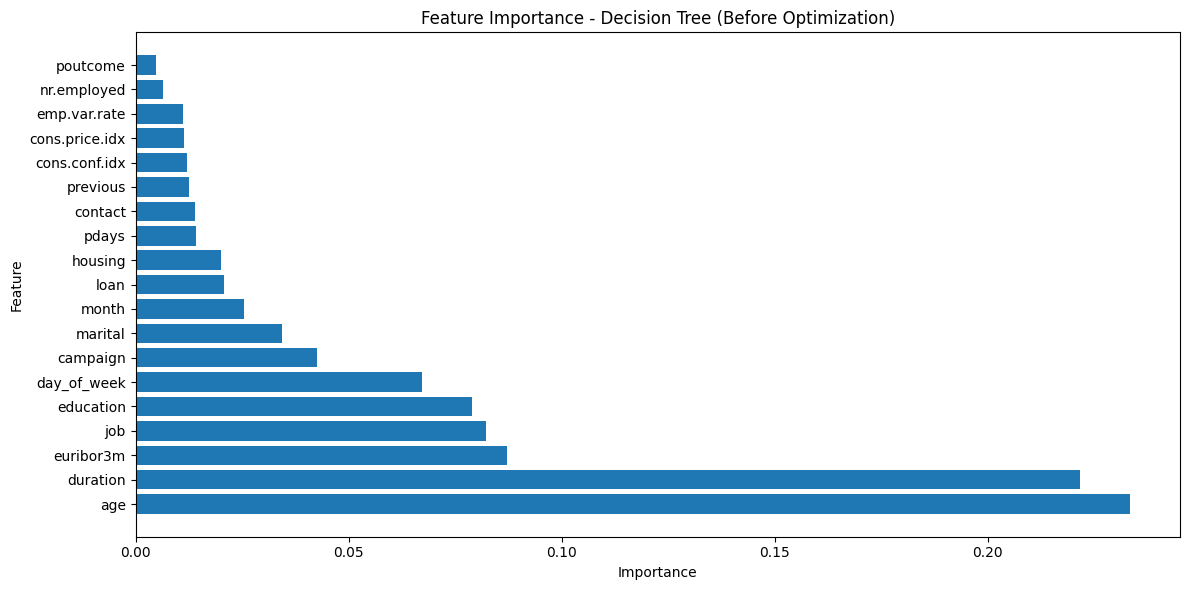

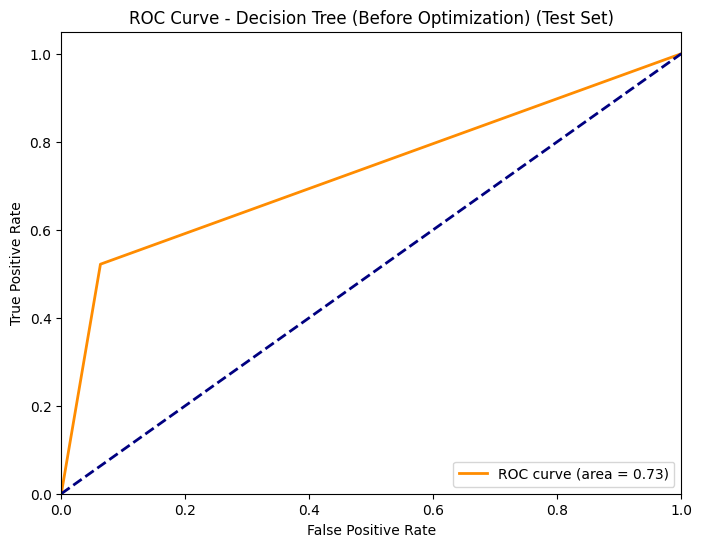

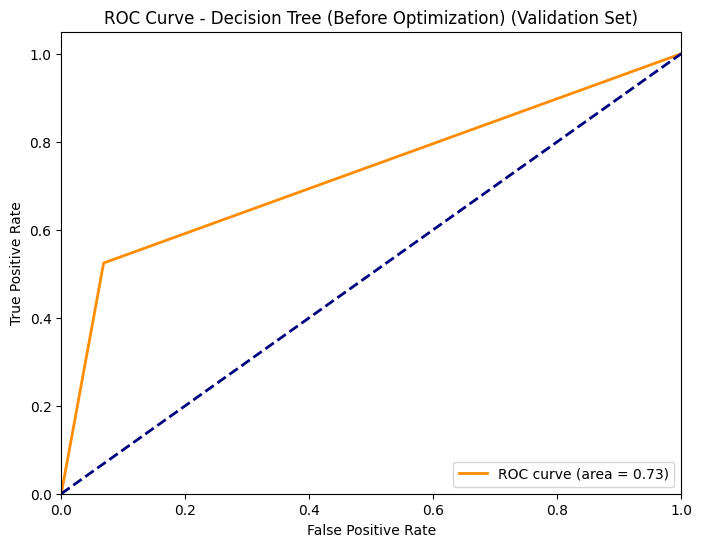

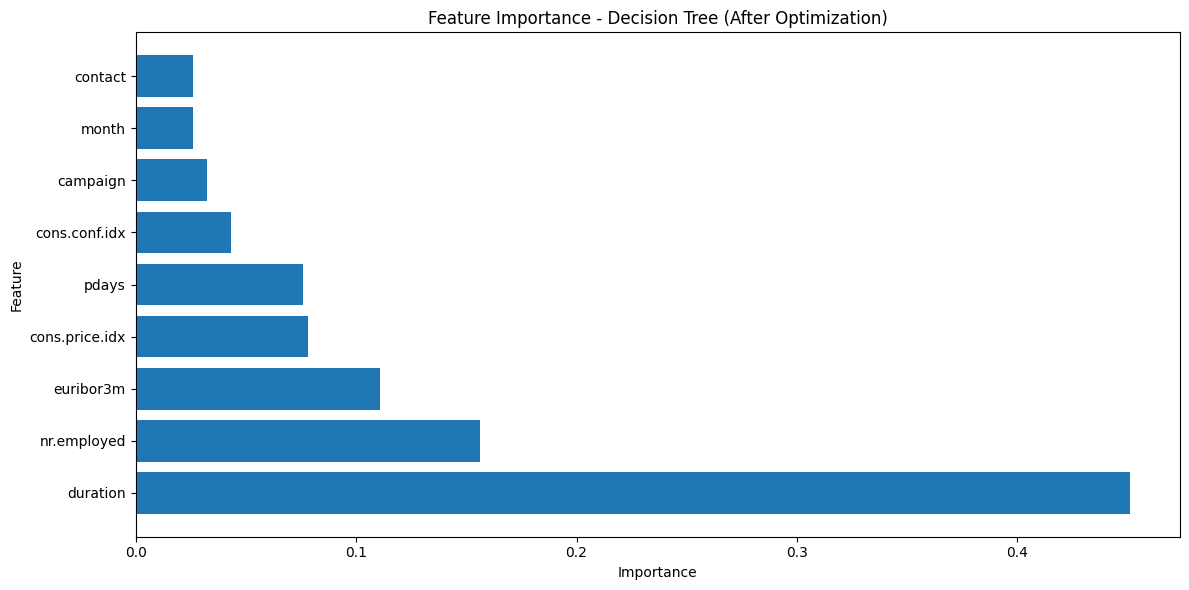

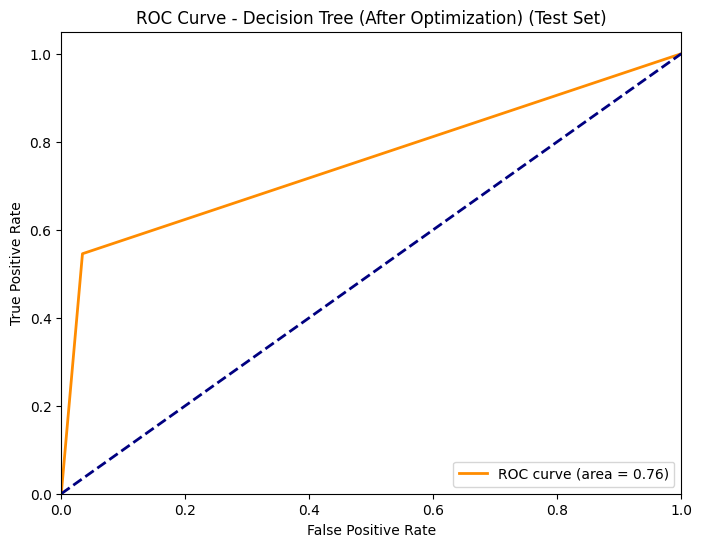

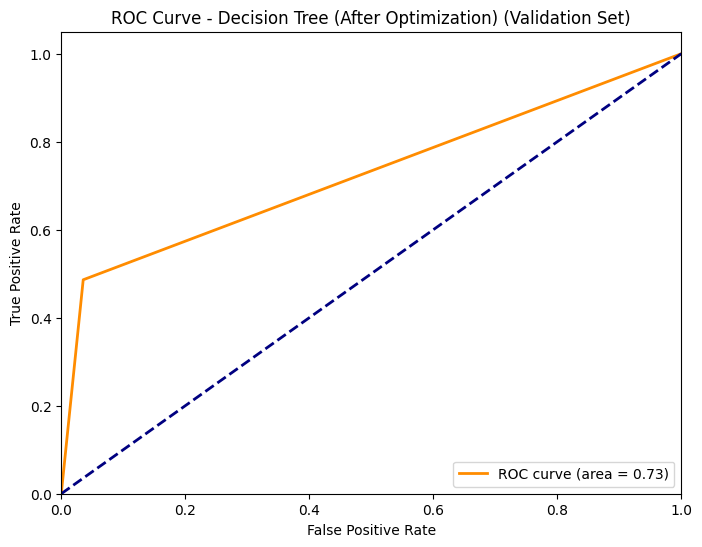

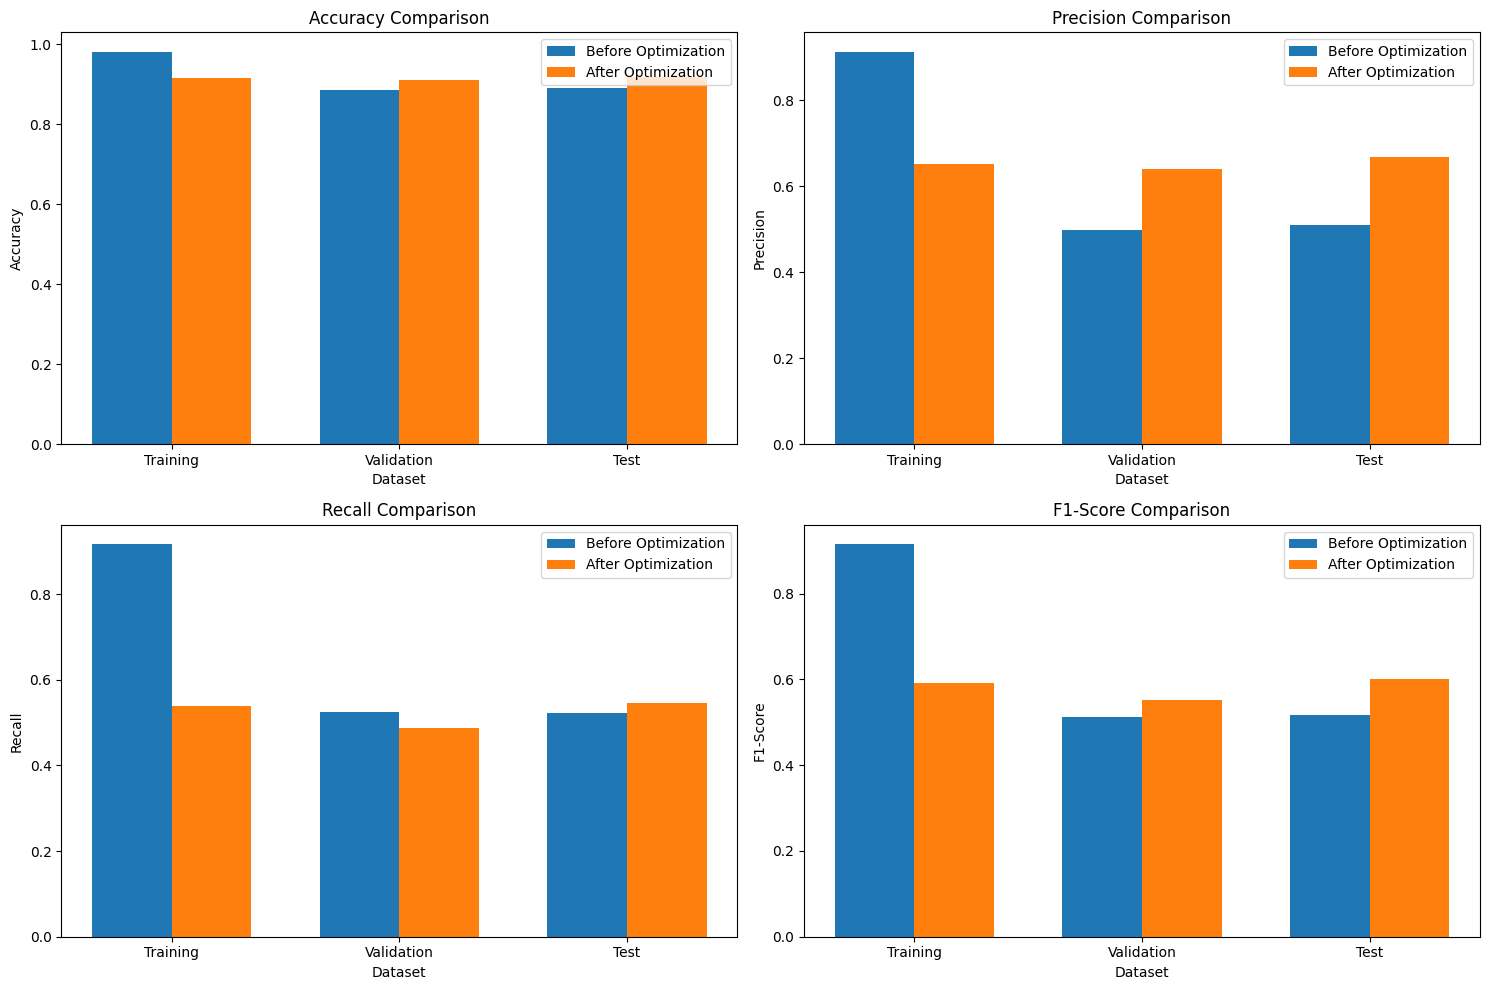

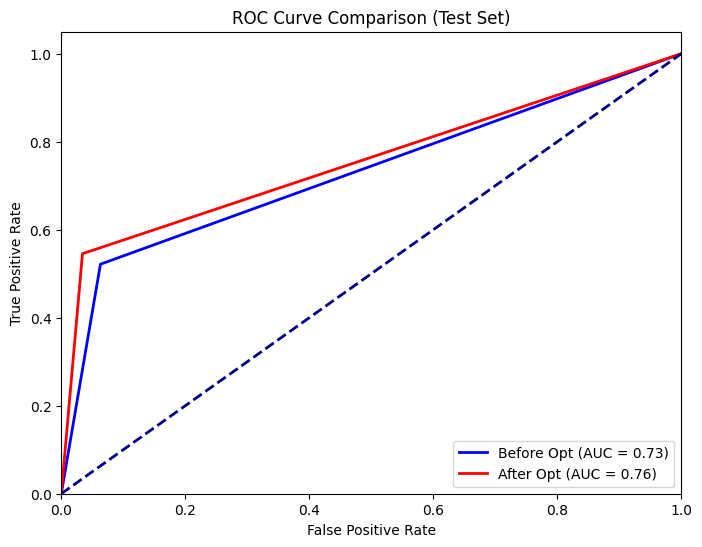

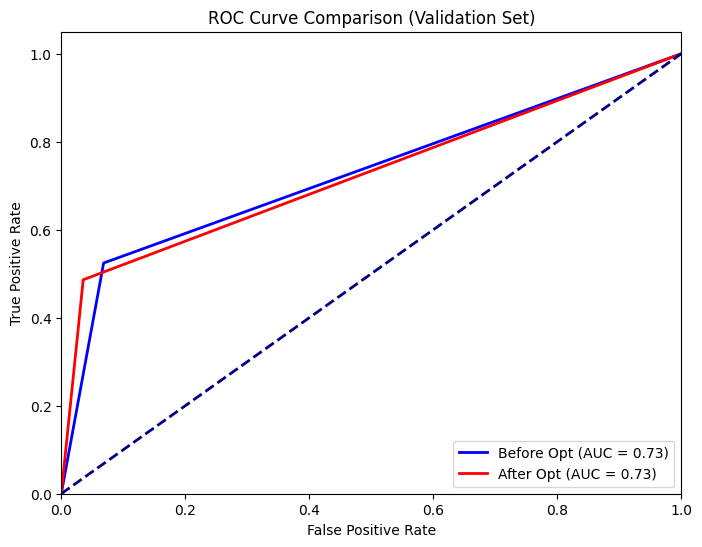

In [4]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Import the DecisionTree class from the previous file
# In a real scenario, you'd import it or have it in the same file
# from decision_tree import DecisionTree

# Create output directories
os.makedirs('data', exist_ok=True)
os.makedirs('beforeOpt', exist_ok=True)
os.makedirs('afterOpt', exist_ok=True)

# Load the datasets
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

# Separate features and target
X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_val = val_df.drop('y', axis=1).values
y_val = val_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Get feature names for later use
feature_names = train_df.drop('y', axis=1).columns.tolist()

# Function to evaluate model and save results
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, output_dir, model_name):
    results = {}
    
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    results['training_time'] = training_time
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    train_cm = confusion_matrix(y_train, y_train_pred).tolist()
    
    # Validation metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
    val_cm = confusion_matrix(y_val, y_val_pred).tolist()
    
    # Test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_cm = confusion_matrix(y_test, y_test_pred).tolist()
    
    # Store results
    results['train'] = {
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1_score': train_f1,
        'confusion_matrix': train_cm
    }
    
    results['validation'] = {
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'confusion_matrix': val_cm
    }
    
    results['test'] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'confusion_matrix': test_cm
    }
    
    # Get feature importance
    feature_importance = model.get_feature_importance()
    feature_importance_dict = {feature_names[int(idx)]: importance for idx, importance in feature_importance.items()}
    
    # Sort feature importance
    sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    results['feature_importance'] = dict(sorted_importance)
    
    # Export tree structure for visualization
    tree_structure = model.export_tree()
    
    # Save results to JSON
    with open(f'{output_dir}/results.json', 'w') as f:
        json.dump(results, f, indent=4)
    
    # Save tree structure to JSON
    with open(f'{output_dir}/tree_structure.json', 'w') as f:
        json.dump(tree_structure, f, indent=4)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    features = list(results['feature_importance'].keys())
    importances = list(results['feature_importance'].values())
    plt.barh(features, importances)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance.png')
    
    # Generate ROC curve for test data
    # For this, we need to modify our model to output probabilities
    # Since we don't have that functionality in our DecisionTree class,
    # we'll use the raw predictions for the ROC curve
    
    # Calculate ROC curve data
    try:
        # For test set
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
        roc_auc_test = auc(fpr_test, tpr_test)
        
        # Plot ROC curve for test data
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc_test:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name} (Test Set)')
        plt.legend(loc="lower right")
        plt.savefig(f'{output_dir}/roc_curve_test.png')
        
        # Store ROC curve data in results
        results['test']['roc'] = {
            'fpr': fpr_test.tolist(),
            'tpr': tpr_test.tolist(),
            'auc': roc_auc_test
        }
        
        # For validation set
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
        roc_auc_val = auc(fpr_val, tpr_val)
        
        # Plot ROC curve for validation data
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc_val:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name} (Validation Set)')
        plt.legend(loc="lower right")
        plt.savefig(f'{output_dir}/roc_curve_val.png')
        
        # Store ROC curve data in results
        results['validation']['roc'] = {
            'fpr': fpr_val.tolist(),
            'tpr': tpr_val.tolist(),
            'auc': roc_auc_val
        }
    except Exception as e:
        print(f"Error generating ROC curve: {e}")
    
    # Print metrics summary
    metrics_summary = f"""
    {model_name} Metrics Summary:
    ===========================
    Training:
      Accuracy: {train_accuracy:.4f}
      Precision: {train_precision:.4f}
      Recall: {train_recall:.4f}
      F1-Score: {train_f1:.4f}
    
    Validation:
      Accuracy: {val_accuracy:.4f}
      Precision: {val_precision:.4f}
      Recall: {val_recall:.4f}
      F1-Score: {val_f1:.4f}
    
    Test:
      Accuracy: {test_accuracy:.4f}
      Precision: {test_precision:.4f}
      Recall: {test_recall:.4f}
      F1-Score: {test_f1:.4f}
    
    Top 5 Important Features:
    """
    
    # Add top 5 features
    for i, (feature, importance) in enumerate(sorted_importance[:5]):
        metrics_summary += f"    {i+1}. {feature}: {importance:.4f}\n"
    
    # Save metrics summary
    with open(f'{output_dir}/metrics_summary.txt', 'w') as f:
        f.write(metrics_summary)
    
    print(metrics_summary)
    
    return model, results

# Part 1: Basic Decision Tree (Before Optimization)
print("Training Decision Tree before optimization...")
dt_basic = DecisionTree(criterion='gini')
dt_basic, before_opt_results = evaluate_model(
    dt_basic, X_train, y_train, X_val, y_val, X_test, y_test, 
    'beforeOpt', 'Decision Tree (Before Optimization)'
)

# Part 2: Optimized Decision Tree (After Pruning)
print("\nTraining Decision Tree with optimization...")
# Train with best hyperparameters 
dt_optimized = DecisionTree(
    max_depth=5,          # Limit tree depth to prevent overfitting
    min_samples_split=5,  # Require more samples to split
    min_impurity_decrease=0.005,  # Require minimum impurity decrease
    criterion='entropy'   # Use entropy instead of Gini
)

# Train the model
dt_optimized.fit(X_train, y_train)

# Apply pruning using validation data
print("Applying pruning...")
try:
    dt_optimized.prune(X_val, y_val)
    print("Pruning completed successfully.")
except Exception as e:
    print(f"An error occurred during pruning: {e}")
    print("Continuing with evaluation without pruning.")

# Evaluate the optimized model
dt_optimized, after_opt_results = evaluate_model(
    dt_optimized, X_train, y_train, X_val, y_val, X_test, y_test, 
    'afterOpt', 'Decision Tree (After Optimization)'
)

# Compare results
print("\nComparison between before and after optimization:")
datasets = ['train', 'validation', 'test']
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

comparison_table = "Metric Comparison (After - Before):\n"
comparison_table += "=" * 40 + "\n"
comparison_table += f"{'Dataset':<12}{'Metric':<12}{'Before':<10}{'After':<10}{'Difference':<10}\n"
comparison_table += "-" * 40 + "\n"

for dataset in datasets:
    for metric in metrics:
        before_val = before_opt_results[dataset][metric]
        after_val = after_opt_results[dataset][metric]
        diff = after_val - before_val
        comparison_table += f"{dataset:<12}{metric:<12}{before_val:<10.4f}{after_val:<10.4f}{diff:<10.4f}\n"

# Save comparison results
with open('comparison_results.txt', 'w') as f:
    f.write(comparison_table)

print(comparison_table)

# Plot comparison of results
plt.figure(figsize=(15, 10))

# Set up the plots
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
datasets_labels = ['Training', 'Validation', 'Test']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    before_values = [before_opt_results[dataset][metric] for dataset in datasets]
    after_values = [after_opt_results[dataset][metric] for dataset in datasets]
    
    x = np.arange(len(datasets_labels))
    width = 0.35
    
    plt.bar(x - width/2, before_values, width, label='Before Optimization')
    plt.bar(x + width/2, after_values, width, label='After Optimization')
    
    plt.xlabel('Dataset')
    plt.ylabel(metrics_labels[i])
    plt.title(f'{metrics_labels[i]} Comparison')
    plt.xticks(x, datasets_labels)
    plt.legend()

plt.tight_layout()
plt.savefig('optimization_comparison.png')

# Compare ROC curves on one plot
try:
    plt.figure(figsize=(8, 6))
    
    # Plot test ROC curves for both models
    if 'roc' in before_opt_results['test'] and 'roc' in after_opt_results['test']:
        # Before optimization ROC
        plt.plot(
            before_opt_results['test']['roc']['fpr'], 
            before_opt_results['test']['roc']['tpr'],
            color='blue', lw=2, 
            label=f'Before Opt (AUC = {before_opt_results["test"]["roc"]["auc"]:.2f})'
        )
        
        # After optimization ROC
        plt.plot(
            after_opt_results['test']['roc']['fpr'], 
            after_opt_results['test']['roc']['tpr'],
            color='red', lw=2, 
            label=f'After Opt (AUC = {after_opt_results["test"]["roc"]["auc"]:.2f})'
        )
        
        # Reference line
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Test Set)')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve_comparison_test.png')
    
    # Also create comparison for validation set
    plt.figure(figsize=(8, 6))
    if 'roc' in before_opt_results['validation'] and 'roc' in after_opt_results['validation']:
        # Before optimization ROC
        plt.plot(
            before_opt_results['validation']['roc']['fpr'], 
            before_opt_results['validation']['roc']['tpr'],
            color='blue', lw=2, 
            label=f'Before Opt (AUC = {before_opt_results["validation"]["roc"]["auc"]:.2f})'
        )
        
        # After optimization ROC
        plt.plot(
            after_opt_results['validation']['roc']['fpr'], 
            after_opt_results['validation']['roc']['tpr'],
            color='red', lw=2, 
            label=f'After Opt (AUC = {after_opt_results["validation"]["roc"]["auc"]:.2f})'
        )
        
        # Reference line
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Validation Set)')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve_comparison_val.png')
except Exception as e:
    print(f"Error generating ROC comparison plots: {e}")

print("\nAll results saved to 'beforeOpt' and 'afterOpt' directories.")
print("Comparison results saved to 'comparison_results.txt' and 'optimization_comparison.png'.")
print("ROC curve comparisons saved to 'roc_curve_comparison_test.png' and 'roc_curve_comparison_val.png'.")